In [78]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler, AutoTokenizer, AutoModelForSequenceClassification
# from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import re

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### BERT-BiLSTM complaint/non-complaint


In [79]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import gc

In [80]:
df_cnc = pd.read_csv("eng_data_cnc.csv")

NaN (float) to empty string

In [81]:
for idx, i in enumerate(df_cnc.loc[:, "SentimentText"]):
    if type(i) == float:
        df_cnc.loc[idx, "SentimentText"] = ""

In [82]:
import time 

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_cnc['SentimentText'].tolist(), df_cnc['label'].tolist(), test_size=0.2, random_state=(time.time_ns() % 943024)
)

In [83]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [84]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.input_ids = torch.tensor(encodings['input_ids'])
        self.attention_mask = torch.tensor(encodings['attention_mask'])
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }
    
train_dataset_cnc = TextDataset(train_texts, train_labels)
val_dataset_cnc = TextDataset(val_texts, val_labels)

train_loader_cnc = DataLoader(train_dataset_cnc, batch_size=32, shuffle=True)
val_loader_cnc = DataLoader(val_dataset_cnc, batch_size=32)

In [5]:
# class BERTBiLSTM(nn.Module):
#     def __init__(self, num_classes, hidden_dim=128, lstm_layers=1, dropout=0.3):
#         super(BERTBiLSTM, self).__init__()
#         self.bert = BertModel.from_pretrained('bert-base-uncased')
#         self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, num_layers=lstm_layers,
#                             batch_first=True, bidirectional=True)
#         self.dropout = nn.Dropout(dropout)
#         self.fc = nn.Linear(hidden_dim * 2, num_classes)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         sequence_output = outputs.last_hidden_state
#         lstm_output, _ = self.lstm(sequence_output)
#         pooled_output = torch.mean(lstm_output, dim=1)
#         x = self.dropout(pooled_output)
#         return self.fc(x)

from transformers import PreTrainedModel, PretrainedConfig

class BertBiLSTMConfig(PretrainedConfig):
    model_type = "bert_bilstm"
    def __init__(self, num_classes=2, hidden_dim=128, lstm_layers=1, dropout=0.3, **kwargs):
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.dropout = dropout
        super().__init__(**kwargs)

class BERTBiLSTM(PreTrainedModel):
    config_class = BertBiLSTMConfig
    
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=config.hidden_dim,
            num_layers=config.lstm_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(config.dropout)
        self.fc = nn.Linear(config.hidden_dim * 2, config.num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        pooled_output = torch.mean(lstm_output, dim=1)
        x = self.dropout(pooled_output)
        return self.fc(x)

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(df_cnc['label'].value_counts())
model = BERTBiLSTM(BertBiLSTMConfig(num_classes=num_classes, lstm_layers=1, hidden_dim=128)).to(device)

EPOCHS = 6

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
total_steps = len(train_loader_cnc) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = nn.CrossEntropyLoss()

In [87]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader_cnc, desc=f"Training Epoch {epoch+1}/{EPOCHS}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_cnc)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_preds, val_targets = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader_cnc, desc=f"Validation Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    print(f"Epoch {epoch+1} Validation Accuracy: {val_acc:.4f}")





Training Epoch 1/6: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s]


Epoch 1 Train Loss: 0.5236


Validation Epoch 1: 100%|██████████| 14/14 [00:03<00:00,  3.90it/s]


Epoch 1 Validation Accuracy: 0.8636


Training Epoch 2/6: 100%|██████████| 55/55 [00:44<00:00,  1.23it/s]


Epoch 2 Train Loss: 0.3713


Validation Epoch 2: 100%|██████████| 14/14 [00:03<00:00,  3.88it/s]


Epoch 2 Validation Accuracy: 0.8636


Training Epoch 3/6: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s]


Epoch 3 Train Loss: 0.2891


Validation Epoch 3: 100%|██████████| 14/14 [00:03<00:00,  3.79it/s]


Epoch 3 Validation Accuracy: 0.8705


Training Epoch 4/6: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s]


Epoch 4 Train Loss: 0.2315


Validation Epoch 4: 100%|██████████| 14/14 [00:03<00:00,  3.79it/s]


Epoch 4 Validation Accuracy: 0.8750


Training Epoch 5/6: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s]


Epoch 5 Train Loss: 0.1862


Validation Epoch 5: 100%|██████████| 14/14 [00:03<00:00,  3.78it/s]


Epoch 5 Validation Accuracy: 0.8750


Training Epoch 6/6: 100%|██████████| 55/55 [00:45<00:00,  1.21it/s]


Epoch 6 Train Loss: 0.1601


Validation Epoch 6: 100%|██████████| 14/14 [00:03<00:00,  3.77it/s]

Epoch 6 Validation Accuracy: 0.8705


In [88]:
print("\nClassification Report:")
labels = ["Non-Complaint", "Complaint"]
print(classification_report(val_targets, val_preds, target_names=labels))


Classification Report:
               precision    recall  f1-score   support

Non-Complaint       0.77      0.83      0.80       134
    Complaint       0.92      0.89      0.91       306

     accuracy                           0.87       440
    macro avg       0.84      0.86      0.85       440
 weighted avg       0.87      0.87      0.87       440



In [89]:
f1_score(val_targets, val_preds, labels=labels)

0.9051580698835274

In [1]:
# Confusion Matrix
cm = confusion_matrix(val_targets, val_preds)
# plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
# plt.title('Confusion Matrix')
plt.show()

NameError: name 'confusion_matrix' is not defined

In [92]:
model.save_pretrained("bert_bilstm_complaint_classifier")
tokenizer.save_pretrained("bert_bilstm_complaint_classifier")
import pickle

with open('val_labels_cnc_bi.pkl', 'wb') as file:
    pickle.dump(val_labels, file)
with open('val_texts_cnc_bi.pkl', 'wb') as file:
    pickle.dump(val_texts, file)


In [12]:
import gc

In [101]:
try: model.cpu()
except: pass

try: del model
except: pass

try: del optimizer
except: pass

try: del scheduler
except: pass

try:
    with torch.no_grad():
        torch.cuda.empty_cache()
except: pass

try: del torch
except: pass

try: del tqdm
except: pass

try: del Dataset, DataLoader, nn, AdamW
except: pass


gc.collect()

8630

In [3]:
! nvidia-smi

Sat May 10 19:17:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off |   00000000:01:00.0 Off |                  N/A |
| N/A   62C    P8             N/A / 5001W |     675MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_scheduler, AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModel, AutoTokenizer, AutoConfig
# from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import re

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

/home/risb/Desktop/BTP2/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model = BERTBiLSTM.from_pretrained("bert_bilstm_complaint_classifier")
tokenizer = AutoTokenizer.from_pretrained("bert_bilstm_complaint_classifier")

In [7]:
model.to(device)

BERTBiLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [8]:
import pickle

with open('val_texts_cnc_bi.pkl', 'rb') as file:
    val_texts = pickle.load(file)  # Deserialize[2][6]
print(val_texts)  # Output: {'name': 'Alice', ...}
with open('val_labels_cnc_bi.pkl', 'rb') as file:
    val_labels = pickle.load(file)  # Deserialize[2][6]
print(val_labels)  # Output: {'name': 'Alice', ...}

['railway is not taking my concern seriously', '56364 ers - srr passenger scheduled time is 17.52 . now it is 18 . 08 . still not come . no announcement too .', "hvn't you the answer ? when will you stop ticket mafia group ? i think your officials are also involved in it 2 / 3", 'train number 12791 coach b2 . no water in toilet since morning . kindly help', 'thank you so much sir . my money has been refunded', 'everyday magadh express 12401 running late 3 to 5 hours without any reson . is anyome have responsibility . p', 'sir kindly increase coaches in trains like begumpura ex 12237 and other to slove waiting list problem', 'at what time the chat vil be prepared ?', 'sir condition of railway colony bareilly junction . for past 5 days . please help', 'at bhubaneswar . men are standing in ladies line and i get to stand at back being a lady . why', 'sir no response from anywhere neither nor tdr rejected ,', 'sir , please read the news paper clipping and please do the needful . only you ca

In [9]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.input_ids = torch.tensor(encodings['input_ids'])
        self.attention_mask = torch.tensor(encodings['attention_mask'])
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

val_dataset_cnc = TextDataset(val_texts, val_labels)
val_loader_cnc = DataLoader(val_dataset_cnc, batch_size=32)

In [10]:
def evaluate(model, val_loader):
    model.eval()
    val_preds, val_targets = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    
    return (val_targets, val_preds)

(val_targets, val_preds) = evaluate(model, val_loader_cnc)

In [11]:
print("\nClassification Report:")
labels = ["Non-Complaint", "Complaint"]
print(classification_report(val_targets, val_preds, target_names=labels))


Classification Report:
               precision    recall  f1-score   support

Non-Complaint       0.77      0.83      0.80       134
    Complaint       0.92      0.89      0.91       306

     accuracy                           0.87       440
    macro avg       0.84      0.86      0.85       440
 weighted avg       0.87      0.87      0.87       440



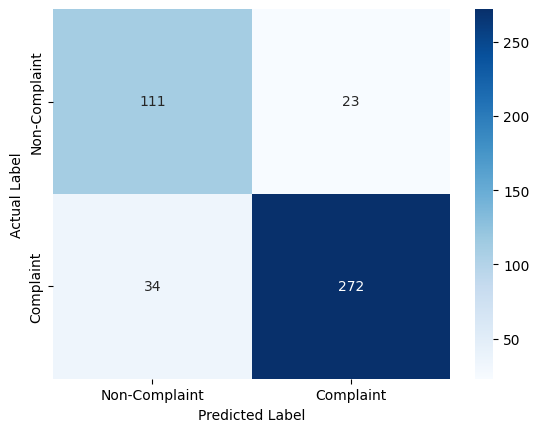

In [12]:
cm = confusion_matrix(val_targets, val_preds)
# plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
# plt.title('Confusion Matrix')
plt.show()

In [13]:
import gc
try: model.cpu()
except: pass

try: del model
except: pass

try: del optimizer
except: pass

try: del scheduler
except: pass

try:
    with torch.no_grad():
        torch.cuda.empty_cache()
except: pass

try: del torch
except: pass

try: del tqdm
except: pass

try: del Dataset, DataLoader, nn, AdamW
except: pass


gc.collect()

4496